In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-iot/test_ML_IOT.csv
/kaggle/input/ml-iot/sample_submission_ML_IOT.csv
/kaggle/input/ml-iot/train_ML_IOT.csv


**Importing necessary packages**

In [133]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Loading Data

In [17]:
data = pd.read_csv("../input/ml-iot/train_ML_IOT.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [18]:
data.shape

(48120, 4)

**Exploratory Data Analysis**

Text(0.5, 0, 'Date')

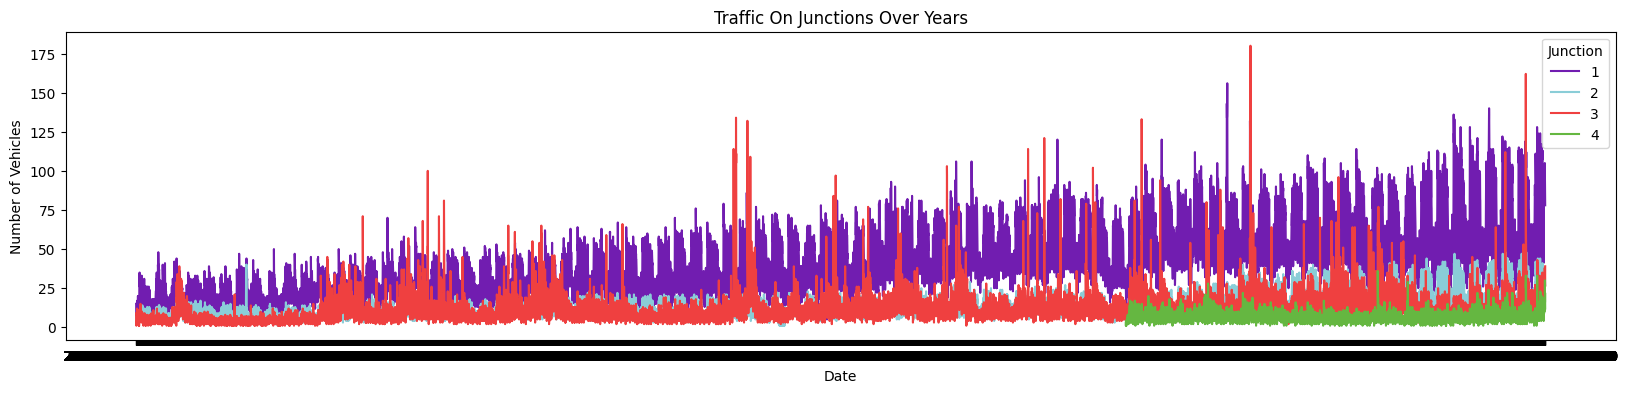

In [21]:
df = data.copy() 
colors = ["#711DB0", "#8ACDD7", "#EF4040", "#65B741"]
plt.figure(figsize=(20,4))
Time_series=sns.lineplot(x=df['DateTime'], y="Vehicles", data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [22]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract Year, Month, Day, and Day Name
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour

print(df.head())

             DateTime  Junction  Vehicles           ID  Year  Month  Day  Hour
0 2015-11-01 00:00:00         1        15  20151101001  2015     11    1     0
1 2015-11-01 01:00:00         1        13  20151101011  2015     11    1     1
2 2015-11-01 02:00:00         1        10  20151101021  2015     11    1     2
3 2015-11-01 03:00:00         1         7  20151101031  2015     11    1     3
4 2015-11-01 04:00:00         1         9  20151101041  2015     11    1     4


In [60]:
# Set the reference date for day name calculation
reference_date = pd.to_datetime('2015-11-01')
df['Day Number'] = (df['DateTime'] - reference_date).dt.days

# Calculate the day name based on the reference date
df['DayName'] = (reference_date + pd.to_timedelta(df['Day Number'], unit='D')).dt.strftime('%A')

df['Weekday'] = df['DateTime'].dt.weekday < 5
df['Weekend'] = ~df['Weekday']


df = df[['Junction', 'Vehicles', 'ID', 'Year', 'Month', 'Day', 'DayName', 'Weekday', 'Weekend']]
print(df.head())

   Junction  Vehicles           ID  Year  Month  Day DayName  Weekday  Weekend
0         1        15  20151101001  2015     11    1  Sunday    False     True
1         1        13  20151101011  2015     11    1  Sunday    False     True
2         1        10  20151101021  2015     11    1  Sunday    False     True
3         1         7  20151101031  2015     11    1  Sunday    False     True
4         1         9  20151101041  2015     11    1  Sunday    False     True


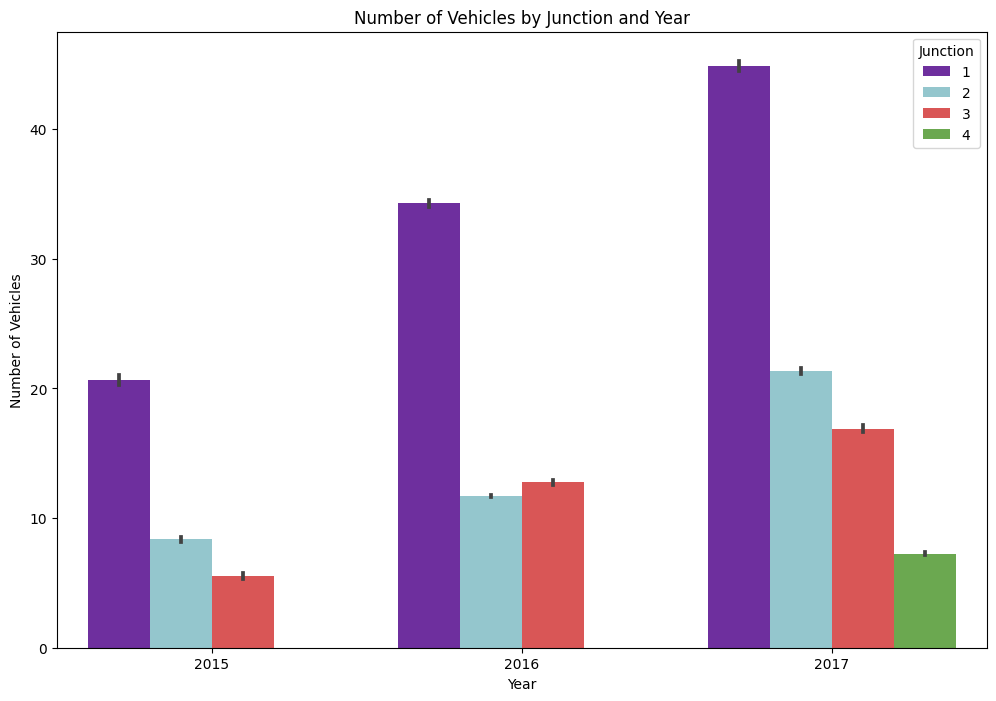

In [61]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Year', y='Vehicles', hue='Junction', data=df, palette=colors)
plt.title('Number of Vehicles by Junction and Year')
plt.xlabel('Year')
plt.ylabel('Number of Vehicles')
plt.show()

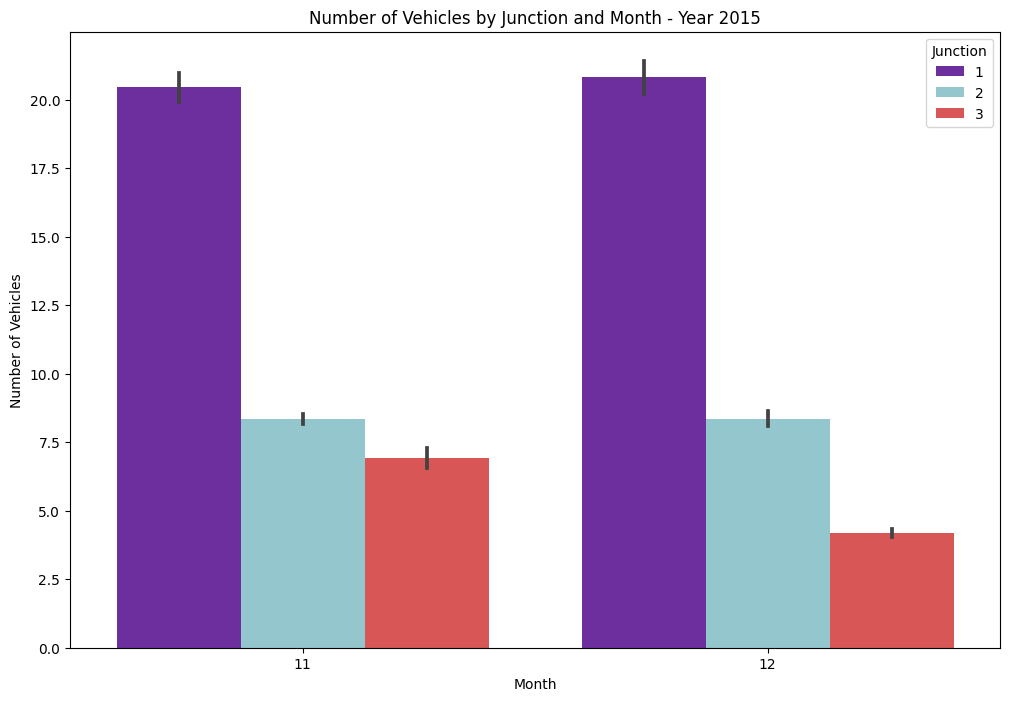

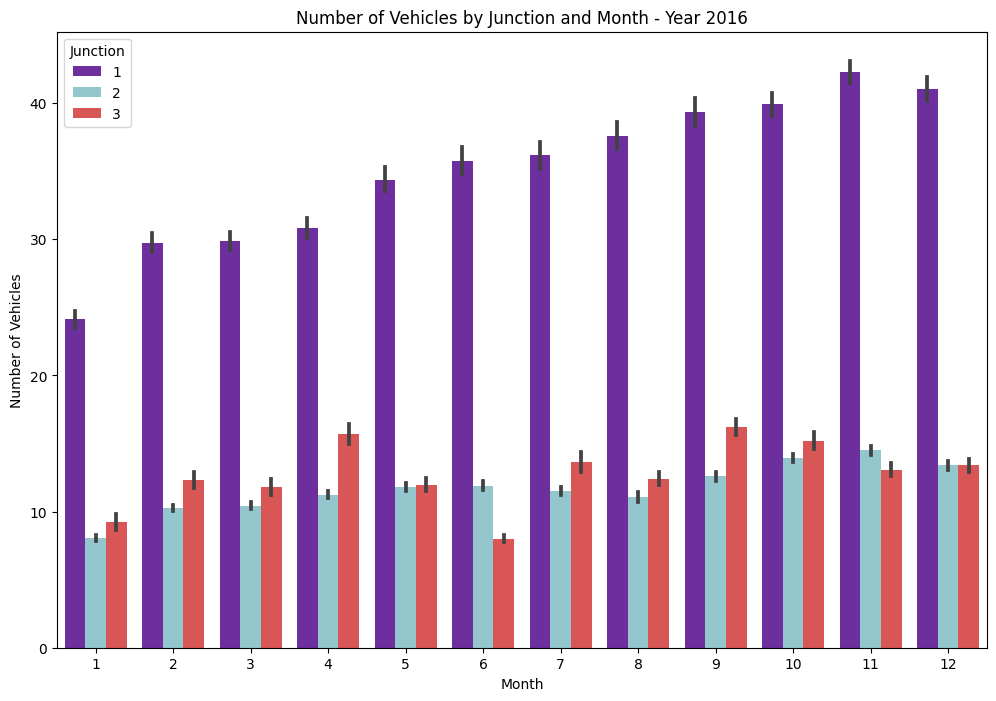

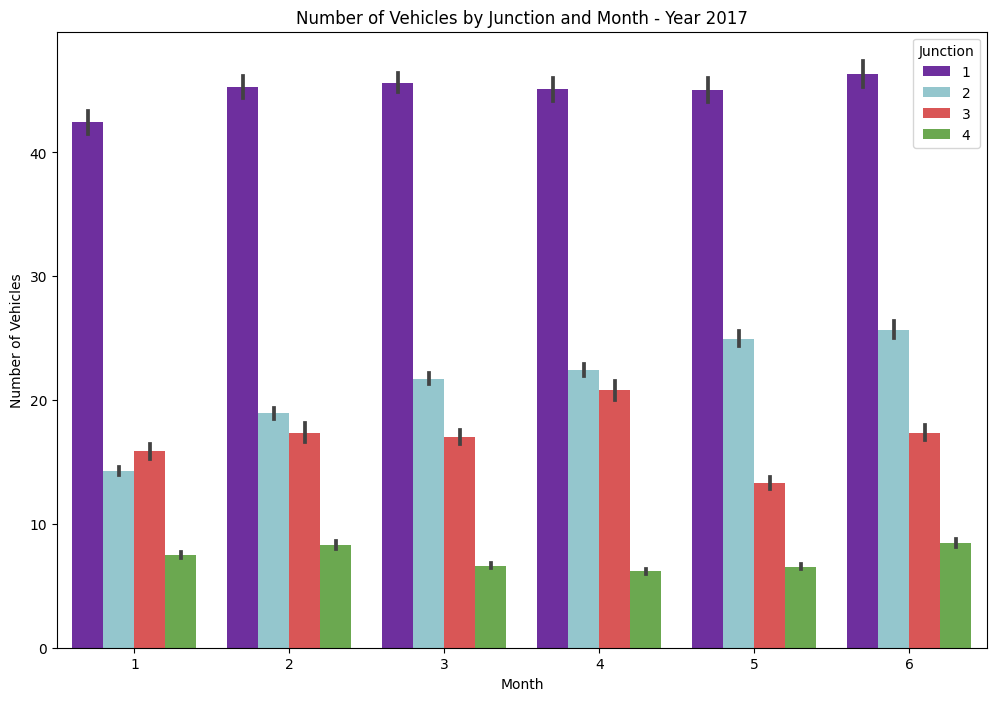

In [62]:
years = df['Year'].unique()

for year in years:
    # Filter data for the current year
    data_year = df[df['Year'] == year]
    
    # Plot for the current year
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Month', y='Vehicles', hue='Junction', data=data_year, palette=colors)
    plt.title(f'Number of Vehicles by Junction and Month - Year {year}')
    plt.xlabel('Month')
    plt.ylabel('Number of Vehicles')
    plt.show()

**Data Cleaning**

We're going to filtre data from missing values and outliers

In [63]:
missing_values = df.isnull().sum()
missing_values

Junction    0
Vehicles    0
ID          0
Year        0
Month       0
Day         0
DayName     0
Weekday     0
Weekend     0
dtype: int64

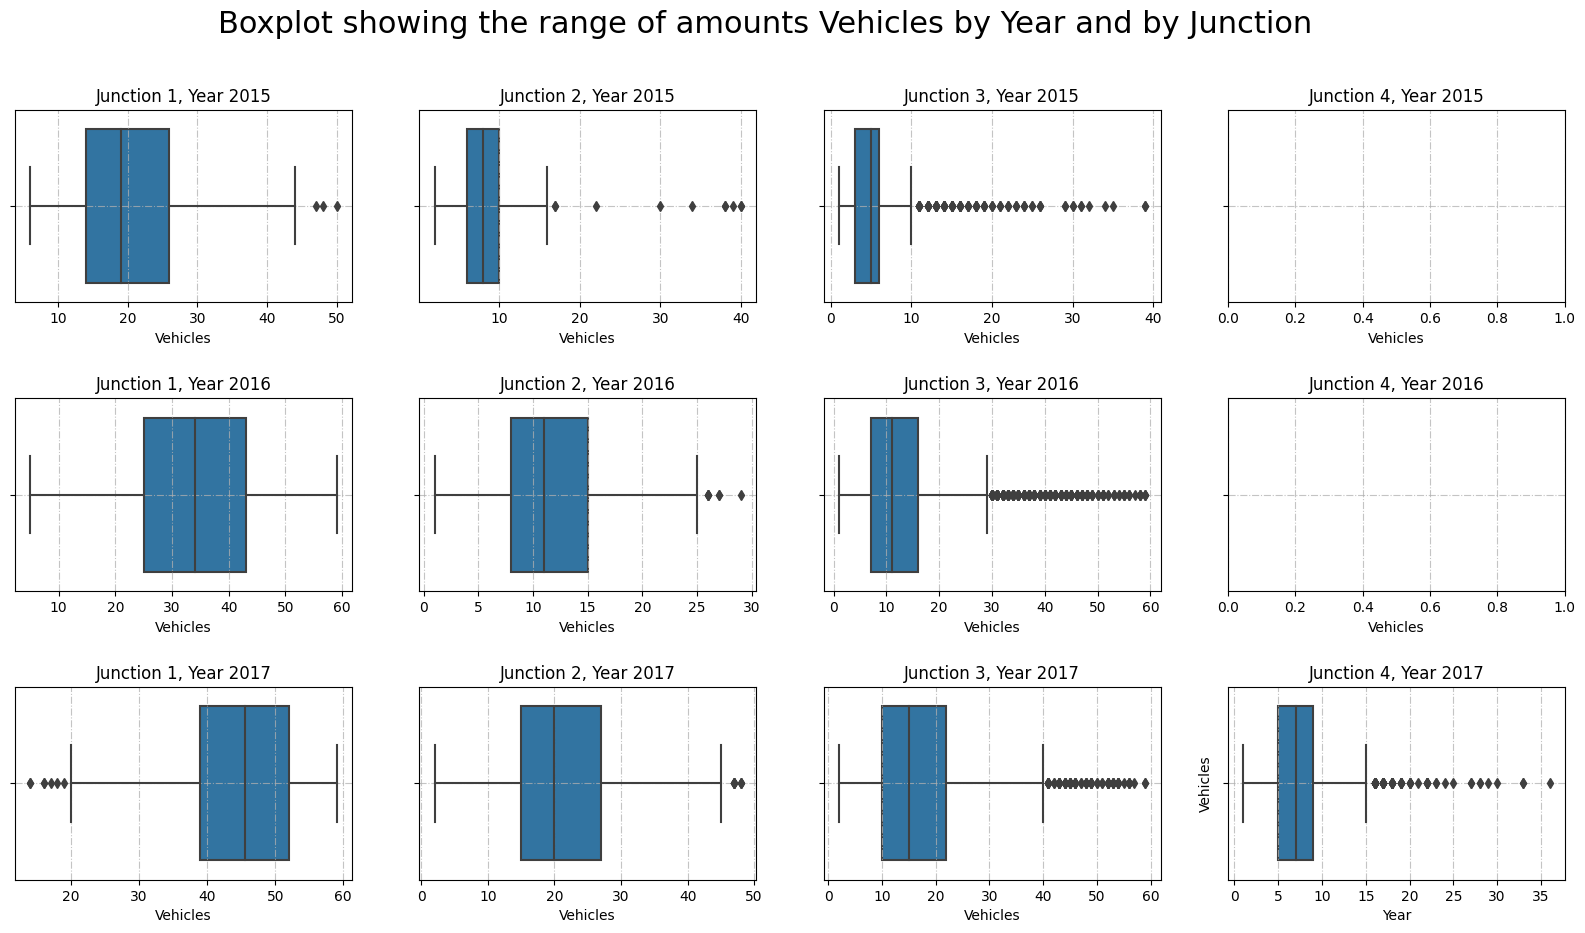

In [64]:
f, axis = plt.subplots(3, 4, figsize=(20, 10))

for i, year in zip(range(3), range(2015, 2018)):
  for j, junction in zip(range(4), range(1, 5)):
    sns.boxplot(x=df[(df["Junction"] == junction) & (df["Year"] == year)]['Vehicles'], ax=axis[i, j])
    axis[i, j].grid(True, alpha=0.75, ls='-.')


junction_names = ['Junction 1', 'Junction 2', 'Junction 3', 'Junction 4']
year = 2015
for i in range(3):
  for j in range(4):
    axis[i, j].set_title(f'{junction_names[j]}, Year {year + i}')


plt.subplots_adjust(hspace=0.5)  # Add this line to increase the space between subplots

plt.xlabel('Year')
plt.ylabel('Vehicles')
f.suptitle('Boxplot showing the range of amounts Vehicles by Year and by Junction', fontsize=22)
plt.show()

In each subplot, a boxplot is plotted visualizing the distribution of the "Vehicles" variable for a particular year and intersection combination

In [65]:
# Filter outliers based on interquartile range (IQR)
Q3 = df['Vehicles'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Vehicles'] >= lower_bound) & (df['Vehicles'] <= upper_bound)]
df

,Junction,Vehicles,ID,Year,Month,Day,DayName,Weekday,Weekend
0,1,15,20151101001,2015,11,1,Sunday,False,True
1,1,13,20151101011,2015,11,1,Sunday,False,True
2,1,10,20151101021,2015,11,1,Sunday,False,True
3,1,7,20151101031,2015,11,1,Sunday,False,True
4,1,9,20151101041,2015,11,1,Sunday,False,True
...,...,...,...,...,...,...,...,...,...
48115,4,11,20170630194,2017,6,30,Friday,True,False
48116,4,30,20170630204,2017,6,30,Friday,True,False
48117,4,16,20170630214,2017,6,30,Friday,True,False
48118,4,22,20170630224,2017,6,30,Friday,True,False


In [66]:
print("Size of original data:", len(data), "Size after filtering outliers:", len(df))

Size of original data: 48120 Size after filtering outliers: 42035


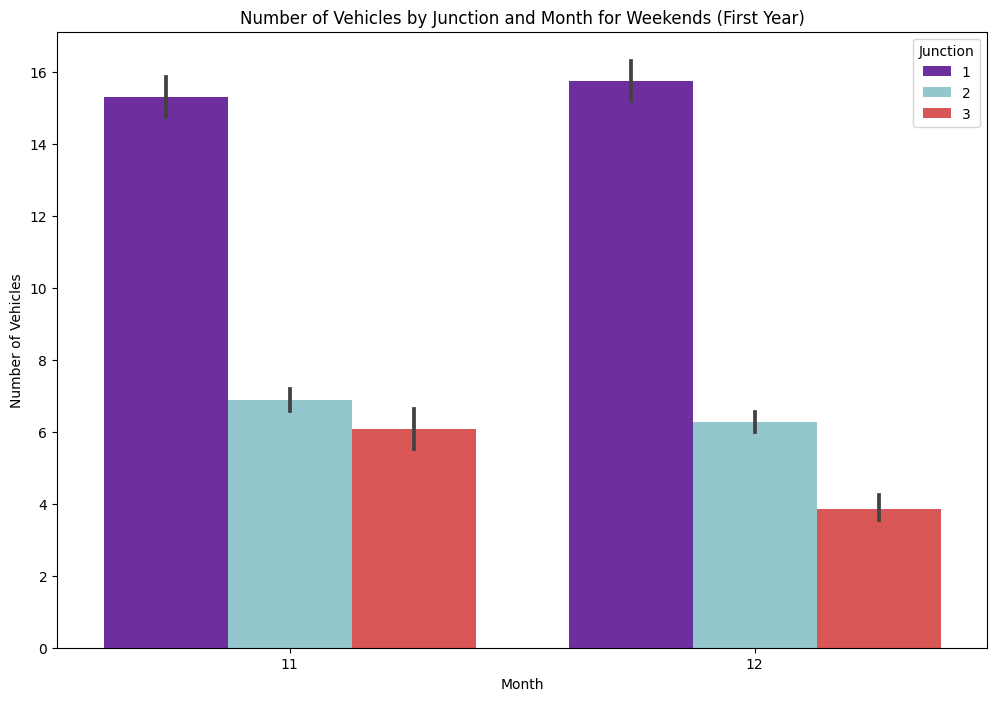

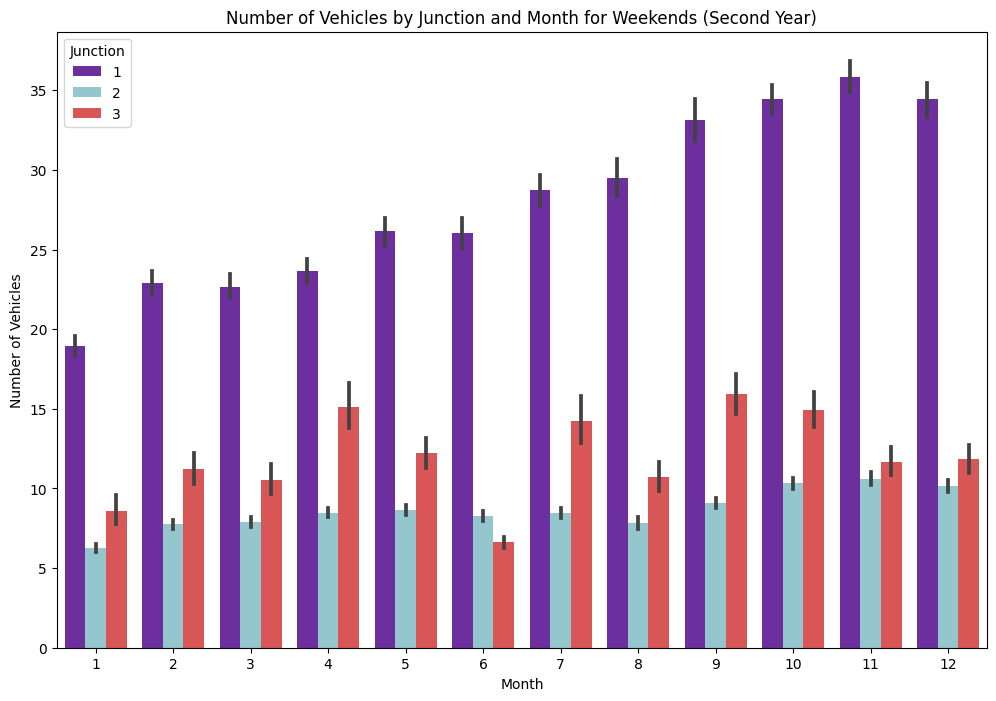

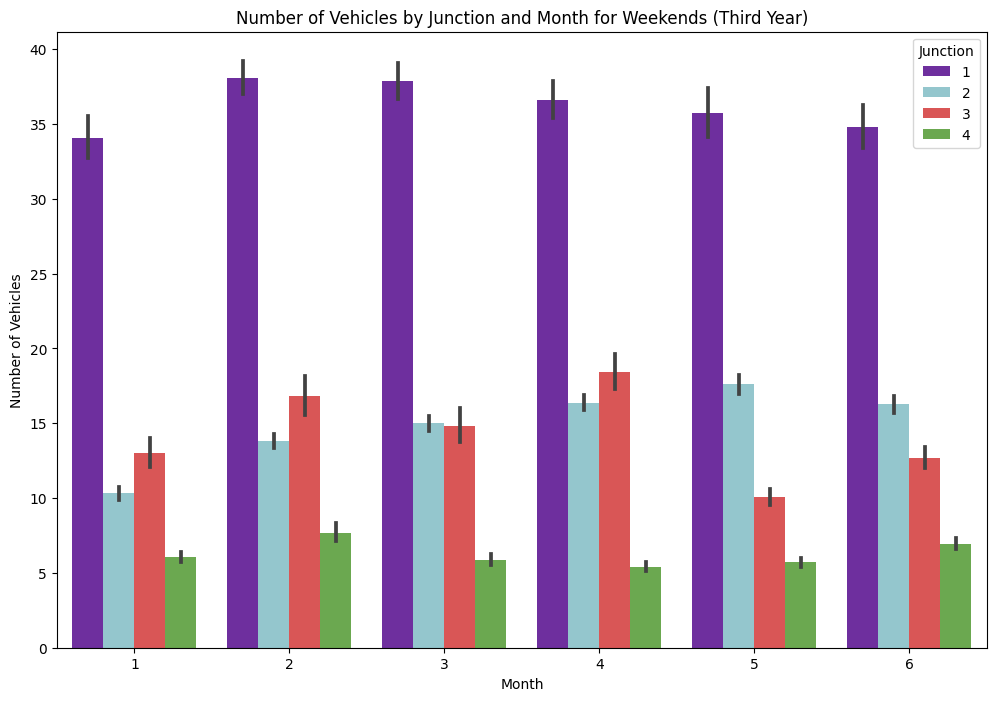

In [67]:
# Filter data for weekends in each year
first_year_weekends = df[(df['Year'] == 2015) & (df['Weekend'] == 1)]
second_year_weekends = df[(df['Year'] == 2016) & (df['Weekend'] == 1)]
third_year_weekends = df[(df['Year'] == 2017) & (df['Weekend'] == 1)]

# Plot for the first year
plt.figure(figsize=(12, 8))
sns.barplot(x='Month', y='Vehicles', hue='Junction', data=first_year_weekends, palette= colors)
plt.title('Number of Vehicles by Junction and Month for Weekends (First Year)')
plt.xlabel('Month')
plt.ylabel('Number of Vehicles')
plt.show()

# Plot for the second year
plt.figure(figsize=(12, 8))
sns.barplot(x='Month', y='Vehicles', hue='Junction', data=second_year_weekends, palette= colors)
plt.title('Number of Vehicles by Junction and Month for Weekends (Second Year)')
plt.xlabel('Month')
plt.ylabel('Number of Vehicles')
plt.show()

# Plot for the third year
plt.figure(figsize=(12, 8))
sns.barplot(x='Month', y='Vehicles', hue='Junction', data=third_year_weekends, palette= colors)
plt.title('Number of Vehicles by Junction and Month for Weekends (Third Year)')
plt.xlabel('Month')
plt.ylabel('Number of Vehicles')
plt.show()


Now we're going to create a different frames for each Junction

In [68]:
test=pd.read_csv("../input/ml-iot/test_ML_IOT.csv")

In [83]:
test['DateTime'] = pd.to_datetime(test['DateTime'])

# Extract Year, Month, Day, and Day Name
test['Year'] = test['DateTime'].dt.year
test['Month'] = test['DateTime'].dt.month
test['Day'] = test['DateTime'].dt.day
test["Hour"]= test['DateTime'].dt.hour

test

,DateTime,Junction,ID,Year,Month,Day,Hour
0,2017-07-01 00:00:00,1,20170701001,2017,7,1,0
1,2017-07-01 01:00:00,1,20170701011,2017,7,1,1
2,2017-07-01 02:00:00,1,20170701021,2017,7,1,2
3,2017-07-01 03:00:00,1,20170701031,2017,7,1,3
4,2017-07-01 04:00:00,1,20170701041,2017,7,1,4
...,...,...,...,...,...,...,...
11803,2017-10-31 19:00:00,4,20171031194,2017,10,31,19
11804,2017-10-31 20:00:00,4,20171031204,2017,10,31,20
11805,2017-10-31 21:00:00,4,20171031214,2017,10,31,21
11806,2017-10-31 22:00:00,4,20171031224,2017,10,31,22


In [86]:
# Set the reference date for day name calculation
reference_date = pd.to_datetime('2015-11-01')
test['Day Number'] = (test['DateTime'] - reference_date).dt.days

# Calculate the day name based on the reference date
test['DayName'] = (reference_date + pd.to_timedelta(test['Day Number'], unit='D')).dt.strftime('%A')

test['Weekday'] = test['DateTime'].dt.weekday < 5
test['Weekend'] = ~test['Weekday']


test = test[['Junction', 'ID', 'Year', 'Month', 'Day', 'DayName', 'Weekday', 'Weekend']]
test

,Junction,ID,Year,Month,Day,DayName,Weekday,Weekend
0,1,20170701001,2017,7,1,Saturday,False,True
1,1,20170701011,2017,7,1,Saturday,False,True
2,1,20170701021,2017,7,1,Saturday,False,True
3,1,20170701031,2017,7,1,Saturday,False,True
4,1,20170701041,2017,7,1,Saturday,False,True
...,...,...,...,...,...,...,...,...
11803,4,20171031194,2017,10,31,Tuesday,True,False
11804,4,20171031204,2017,10,31,Tuesday,True,False
11805,4,20171031214,2017,10,31,Tuesday,True,False
11806,4,20171031224,2017,10,31,Tuesday,True,False


In [107]:
features = ['Junction', 'Vehicles', 'ID', 'Year', 'Month', 'Weekend']


In [109]:
def create_sequences(df, sequence_length):
    sequences = []
    for i in range(len(df) - sequence_length):
        sequence = df.iloc[i:i+sequence_length]
        sequences.append(sequence.values)
    return np.array(sequences)

In [111]:
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [112]:
sequence_length = 10  # You may adjust this based on your data
sequences = create_sequences(df[features], sequence_length)

In [114]:
X = sequences[:, :-1, :]  # Input sequence
y = sequences[:, -1, 1] 

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
model = Sequential()
model.add(GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [136]:
opt= SGD(learning_rate=0.01, momentum=0.9)

In [139]:
model.compile(optimizer=opt, loss='mean_squared_error')

In [140]:
early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

In [141]:
history = model.fit(X_train, y_train, epochs=50, batch_size=120, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
281/281 [==============================] - 9s 19ms/step - loss: 0.0231 - val_loss: 0.0116
Epoch 2/50
281/281 [==============================] - 5s 17ms/step - loss: 0.0134 - val_loss: 0.0106
Epoch 3/50
281/281 [==============================] - 5s 17ms/step - loss: 0.0122 - val_loss: 0.0099
Epoch 4/50
281/281 [==============================] - 5s 17ms/step - loss: 0.0114 - val_loss: 0.0094
Epoch 5/50
281/281 [==============================] - 5s 17ms/step - loss: 0.0107 - val_loss: 0.0089
Epoch 6/50
281/281 [==============================] - 5s 18ms/step - loss: 0.0103 - val_loss: 0.0084
Epoch 7/50
281/281 [==============================] - 5s 17ms/step - loss: 0.0098 - val_loss: 0.0081
Epoch 8/50
281/281 [==============================] - 5s 17ms/step - loss: 0.0095 - val_loss: 0.0078
Epoch 9/50
281/281 [==============================] - 5s 18ms/step - loss: 0.0092 - val_loss: 0.0075
Epoch 10/50
281/281 [==============================] - 5s 17ms/step - loss: 0.0090 - val_lo

In [144]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

263/263 [==============================] - 1s 4ms/step - loss: 0.0069
Test Loss: 0.006943366024643183


In [147]:
predictions = model.predict(X_test)

263/263 [==============================] - 1s 4ms/step


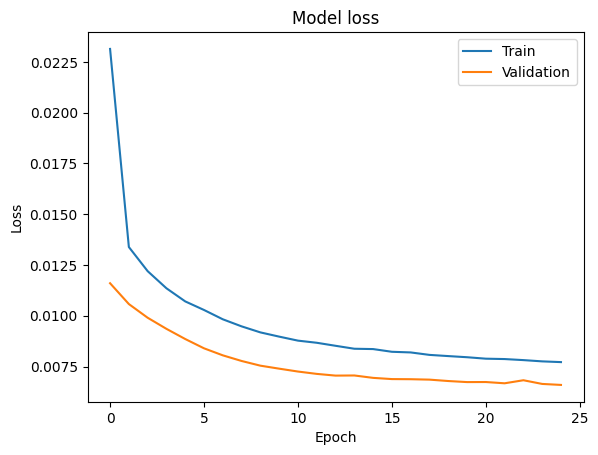

In [143]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()